In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import Dataset
import torch
print("Successful import")


Successful import


In [2]:
# Step 1: Load and preprocess data
df = pd.read_csv('data21.txt', sep='\t', quoting=3, engine ='python',on_bad_lines='skip')
df.dropna(subset=['Text','Cause'],inplace=True)
print('Initial shape:', df.shape)

Initial shape: (6799, 2)


In [3]:
# Step 2: Encode the labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Cause'])

In [4]:
# Step 3: Tokenization
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def tokenize_function(example):
    return tokenizer(example['Text'], truncation=True, padding='max_length', max_length=128)
print("Successful Tokenization")

Successful Tokenization


In [5]:
# Step 4: Convert to Hugging Face Dataset
dataset = Dataset.from_pandas(df[['Text', 'label']])
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.2)
print("Successful Conversion")

Map:   0%|          | 0/6799 [00:00<?, ? examples/s]

Successful Conversion


In [6]:
# Step 5: Load model
num_labels = len(label_encoder.classes_)
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Step 6: Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=8,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
)

C:\Users\chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [8]:
# Step 7: Compute metrics
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1': f1_score(labels, predictions, average='weighted'),
    }

In [9]:
from transformers import EarlyStoppingCallback

# Step 8: Train
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],  # Stops if no improvement for 3 evals
)

trainer.train()
print("Successful Training")

C:\Users\chris\AppData\Local\Temp\ipykernel_3020\1588889945.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.962795,0.735294,0.732935
2,1.355800,0.669227,0.796324,0.797542
3,0.527800,0.661194,0.786765,0.786870
4,0.527800,0.746301,0.792647,0.792790
5,0.242100,0.740342,0.802941,0.804283
6,0.115100,0.787868,0.796324,0.796804
7,0.115100,0.834848,0.787500,0.788750
8,0.058200,0.850850,0.791176,0.792141


Successful Training


In [10]:
# Step 9: Evaluate
eval_results = trainer.evaluate()
print("Evaluation:", eval_results)

Evaluation: {'eval_loss': 0.7403423190116882, 'eval_accuracy': 0.8029411764705883, 'eval_f1': 0.8042827567931101, 'eval_runtime': 162.2296, 'eval_samples_per_second': 8.383, 'eval_steps_per_second': 0.524, 'epoch': 8.0}


In [11]:
# Step 10: Classification report
predictions = trainer.predict(tokenized_dataset['test'])
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids
target_names = [str(cls) for cls in label_encoder.classes_]
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=target_names))



Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.84      0.83       198
         1.0       0.69      0.80      0.74       162
         2.0       0.73      0.78      0.75       125
         3.0       0.89      0.91      0.90        97
         4.0       0.97      0.89      0.93        35
         5.0       0.84      0.75      0.79        79
         6.0       0.84      0.78      0.81       158
         7.0       0.69      0.74      0.72       129
         8.0       0.78      0.76      0.77       113
         9.0       0.86      0.78      0.82       170
        10.0       0.94      0.87      0.91        94

    accuracy                           0.80      1360
   macro avg       0.82      0.81      0.82      1360
weighted avg       0.81      0.80      0.80      1360



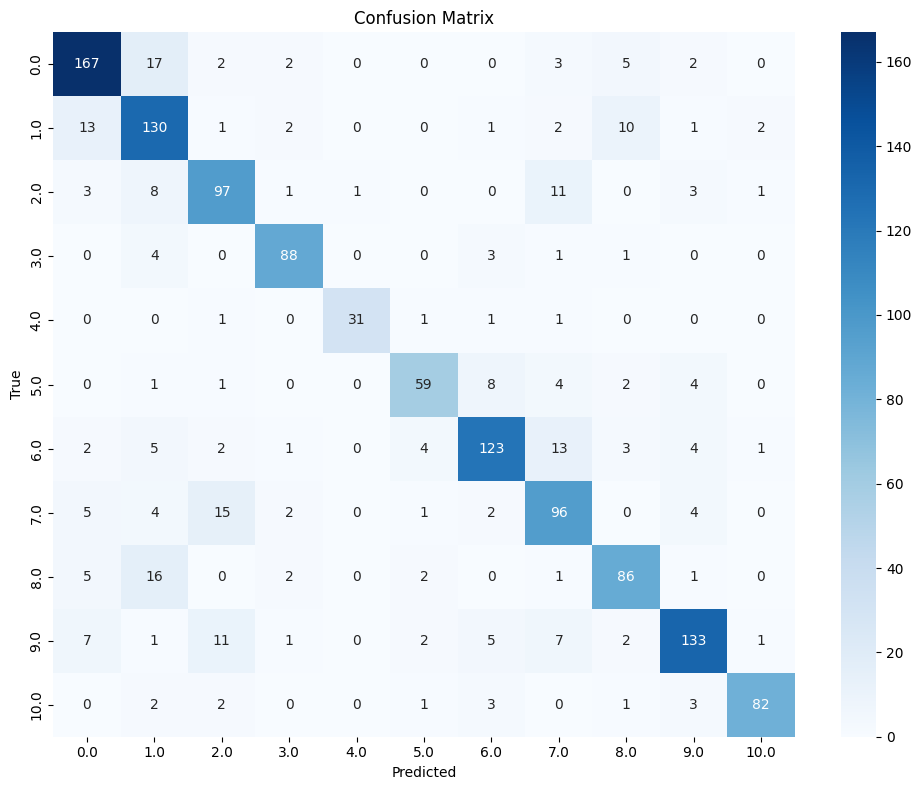

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Convert class labels to string (if needed)
target_names = [str(cls) for cls in label_encoder.classes_]

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
